In [1]:
#ABILITà Informatiche
#dati Veneto blocco 21

In [2]:
import numpy as np
import imageio
import matplotlib
import scipy
from scipy.optimize import minimize
from scipy import ndimage as ndi
from matplotlib import pyplot as plt
import json
import emcee
%matplotlib notebook

In [3]:
indata = open('dpc-covid19-ita-regioni.json')
info = json.load(indata)

In [4]:
info[20]

{'data': '2020-02-24T18:00:00',
 'stato': 'ITA',
 'codice_regione': 5,
 'denominazione_regione': 'Veneto',
 'lat': 45.43490485,
 'long': 12.33845213,
 'ricoverati_con_sintomi': 12,
 'terapia_intensiva': 4,
 'totale_ospedalizzati': 16,
 'isolamento_domiciliare': 16,
 'totale_positivi': 32,
 'variazione_totale_positivi': 0,
 'nuovi_positivi': 32,
 'dimessi_guariti': 0,
 'deceduti': 1,
 'casi_da_sospetto_diagnostico': None,
 'casi_da_screening': None,
 'totale_casi': 33,
 'tamponi': 2200,
 'casi_testati': None,
 'note': None,
 'ingressi_terapia_intensiva': None,
 'note_test': None,
 'note_casi': None,
 'totale_positivi_test_molecolare': None,
 'totale_positivi_test_antigenico_rapido': None,
 'tamponi_test_molecolare': None,
 'tamponi_test_antigenico_rapido': None,
 'codice_nuts_1': None,
 'codice_nuts_2': None}

In [9]:
len(info)

21252

In [10]:
data_tot = []
casi_tot = []

for i in range(1012):
    data_tot.append(info[20 + i*21]['data'])
    casi_tot.append(info[20 + i*21]['totale_casi'])

<IPython.core.display.Javascript object>


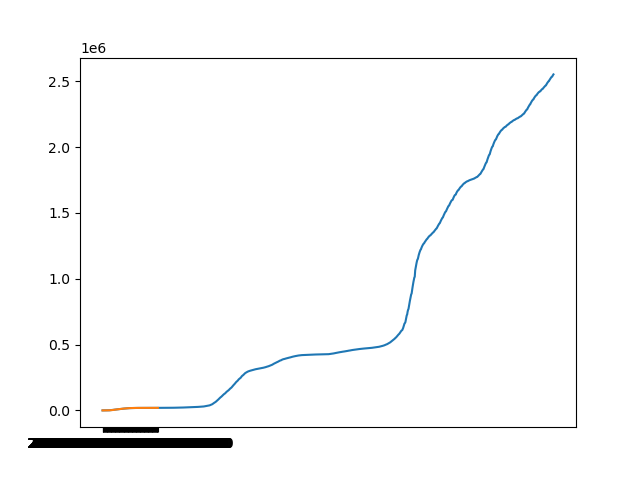

In [11]:
plt.figure()
plt.plot(casi_tot)

In [12]:
data = []
casi = []
N = 125

for i in range(N):
    data.append(info[20 + i*21]['data'])
    casi.append(info[20 + i*21]['totale_casi'])
    
plt.plot(data, casi)

casi_dif = np.zeros(N-1)
for t in range(N-1):
        casi_dif[t] = casi[t+1] - casi[t]

In [13]:
#funzione di gompertz

In [14]:
def gompertz(N, t0, ni, b):
    '''
    calcolo della funzione di gompertz per N punti con t0 tempo di inizio, ni plateau della popolazione/dimensione popolazione, 
    b rate di crescita iniziale e n0 popolazione iniziale
    output funzione di gompertz e funzione di gompertz differenziale
    '''
    gomp = np.zeros(N)
    k = np.log(ni)
    for t in range(N):
        gomp[t] = np.exp( k * ( 1 - np.exp( -b * (t-t0) ) ) )

    gomp_diff = np.zeros(N-1)
    for t in range(N-1):
            gomp_diff[t] = gomp[t+1] - gomp[t]
            
    return gomp, gomp_diff

<IPython.core.display.Javascript object>


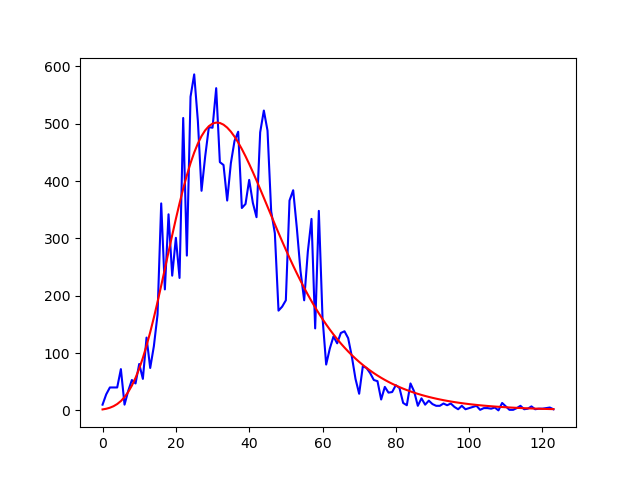

[  1.68461685   2.8607049    4.66550867   7.32753439  11.11091397
  16.30426888  23.20440178  32.09598235  43.22908895  56.79689246
  72.91584864  91.61049802 112.80442196 136.31817749 161.87425621
 189.10840109 217.58605526 246.82236058 276.30398199 305.51108629
 333.93801081 361.11146526 386.60546701 410.05257007 431.15127504
 449.66977915 465.44642896 478.38737354 488.46198619 495.69663951
 500.16739301 501.99209716 501.3223443  498.33561525 493.22788738
 486.20689287 477.48614596 467.2797998  455.79834553 443.24512976
 429.81364007 415.68549008 401.02902566 385.99846887 370.73351658
 355.35931409 339.98672959 324.71286247 309.62172641 294.78505593
 280.2631933  266.10601958 252.35390093 239.03862676 226.18432216
 213.80832124 201.92199194 190.53150626 179.63855217 169.24098575
 159.33342385 149.90777828 140.95373426 132.45917572 124.41056095
 116.79325231 109.59180348 102.79020818  96.37211393  90.32100431
  84.6203531   79.25375335  74.20502438  69.45829917  64.99809482
  60.80936

In [37]:
#prova con casi
t0 = -1
b = 0.07
ni = 19500

prova, diff = gompertz(N, t0, ni, b)

dati_casi = [x for x in casi_dif]

plt.figure()
plt.plot(dati_casi, color='blue')
plt.plot(diff, color='red')
print(diff)

In [16]:
#poisson likelihood

In [53]:
def log_likelihood(dati, predizione):
    '''
    calcolo del logaritmo poisson-likelihood per i dati usando come modello predizione (entrambi array) 
    '''
    predizione = [abs(x) + .01 for x in predizione]
    # -log(likelihood) = L
    L = np.sum(-np.log(predizione)*dati + predizione )
        
    # non c'è fattoriale perchè non serve per minimizzare (log(dati[i]!) non dipende dal modello)
    return L 

<IPython.core.display.Javascript object>


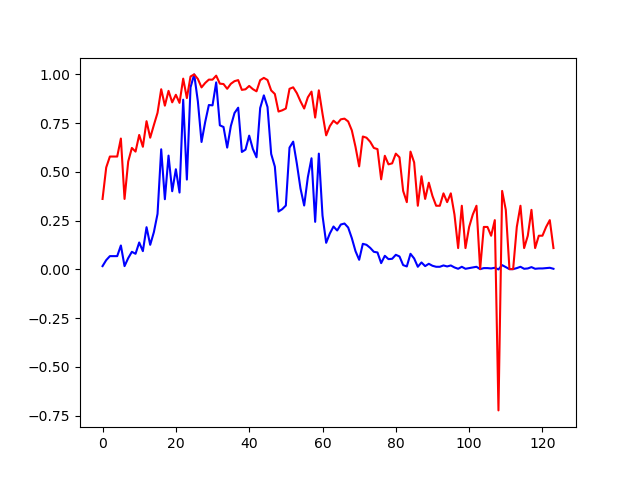

In [54]:
#prova casi
stima = diff
dati = [x for x in casi_dif]

sol = minimize(log_likelihood, stima, dati)

dati_nor = [x/max(dati) for x in dati]

sol_nor = sol.x/max(sol.x)

plt.figure()
plt.plot(dati_nor, color='blue')
plt.plot(sol_nor, color='red')

In [55]:
#emcee guida(https://emcee.readthedocs.io/en/stable/)

In [56]:
def log_likelihood_gompertz(theta, dati):
    '''
    calcolo del logaritmo poisson-likelihood per i dati (array) usando come modello la funzione di gompertz (vedi fun gompertz) 
    '''
    t0, ni, b = theta
    N = len(dati) + 1
    modello, dif = gompertz(N, t0, ni, b)
    
    # -log(likelihood) = L
    L = log_likelihood(dati, dif)   
    # non c'è fattoriale perchè non serve per minimizzare (log(dati[i]!) non dipende dal modello)
    
    return L

In [57]:
#np.random.seed(7)
t0 = -np.random.randint(0, 5)
ni = max(casi) + 500 * np.random.uniform(-1,1)
b = np.random.uniform()

modello, diff_modello = gompertz(N, t0, ni, b)

'''
print(t0, ni, b)
plt.figure()
#plt.plot(modello)
plt.plot(diff_modello)
'''

'\nprint(t0, ni, b)\nplt.figure()\n#plt.plot(modello)\nplt.plot(diff_modello)\n'

[0.00000000e+00 1.52998081e+02 7.42388404e-02]
[-2.44410268e+00  1.93135188e+04  6.81100667e-02]


<IPython.core.display.Javascript object>


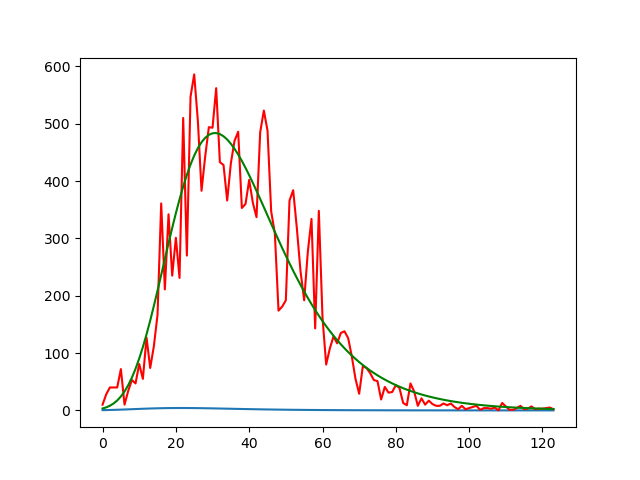

In [59]:
nll = lambda *args: log_likelihood_gompertz(*args)
dati = [x for x in casi_dif]

t0 = -np.random.randint(0, 5)
ni = max(dati) + 500 * np.random.uniform(-0.9,0.9)
b = np.random.uniform(0.05, 0.1)
parametri = np.array([t0, ni, b])

soln = minimize(nll, parametri, args=(dati))
print(parametri)
print(soln.x)
t01, ni1, b1 = soln.x

modello, diff_modello = gompertz(N, t0, ni, b)
modello1, diff_modello1 = gompertz(N, t01, ni1, b1)

plt.figure()
plt.plot(diff_modello)
plt.plot(dati, color='red')
plt.plot(diff_modello1, color='green')

In [65]:
#distribuzione prob parametri è costante, lo è anche il logaritmo, lo si ignora per minimizzazione

def log_prior(theta):
    t0, ni, b = theta
    if t0 <= 0 and 0.0 < ni and 0.0 < b < 1.0:
        return 0.0
    return -np.inf
    

#log_probability = log_likelihood_gompertz + log_prior(=cost) = log_likelihood_gompertz
'''
def log_probability(theta, dati):
    lp = log_prior(theta)
    return lp + log_likelihood_gompertz(theta, dati)
'''

def log_probability(theta, dati):
    lp = log_prior(theta)
    ll = log_likelihood_gompertz(theta, dati)
    if not np.isfinite(lp):
        return -np.inf
    return (lp + ll)

#log_probability = log_likelihood_gompertz(parametri, dati)

In [83]:
#simulazione
dati_in = [x for x in casi_dif]
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(dati_in))
sampler.run_mcmc(pos, 1000, progress=True);

emcee: Exception while calling your likelihood function:
  params: [-2.44405358e+00  1.93135186e+04  6.81976119e-02]
  args: [10.0, 28.0, 40.0, 40.0, 40.0, 72.0, 10.0, 34.0, 53.0, 47.0, 81.0, 55.0, 127.0, 74.0, 112.0, 167.0, 361.0, 211.0, 342.0, 235.0, 301.0, 231.0, 510.0, 270.0, 547.0, 586.0, 505.0, 383.0, 443.0, 494.0, 493.0, 562.0, 433.0, 428.0, 366.0, 431.0, 470.0, 486.0, 353.0, 360.0, 402.0, 362.0, 337.0, 485.0, 523.0, 488.0, 347.0, 309.0, 174.0, 181.0, 192.0, 366.0, 384.0, 318.0, 243.0, 192.0, 277.0, 334.0, 143.0, 348.0, 162.0, 80.0, 108.0, 129.0, 117.0, 135.0, 138.0, 126.0, 94.0, 55.0, 29.0, 77.0, 74.0, 65.0, 53.0, 51.0, 19.0, 41.0, 31.0, 32.0, 44.0, 39.0, 13.0, 9.0, 47.0, 33.0, 8.0, 21.0, 10.0, 17.0, 11.0, 8.0, 8.0, 12.0, 9.0, 12.0, 6.0, 2.0, 8.0, 2.0, 4.0, 6.0, 8.0, 1.0, 4.0, 4.0, 3.0, 5.0, 0.0, 13.0, 7.0, 1.0, 1.0, 4.0, 8.0, 2.0, 3.0, 7.0, 2.0, 3.0, 3.0, 4.0, 5.0, 2.0]
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "C:\Users\march\anaconda3\lib\site-packages\emcee\ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
TypeError: log_probability() takes 2 positional arguments but 125 were given


TypeError: log_probability() takes 2 positional arguments but 125 were given

<IPython.core.display.Javascript object>


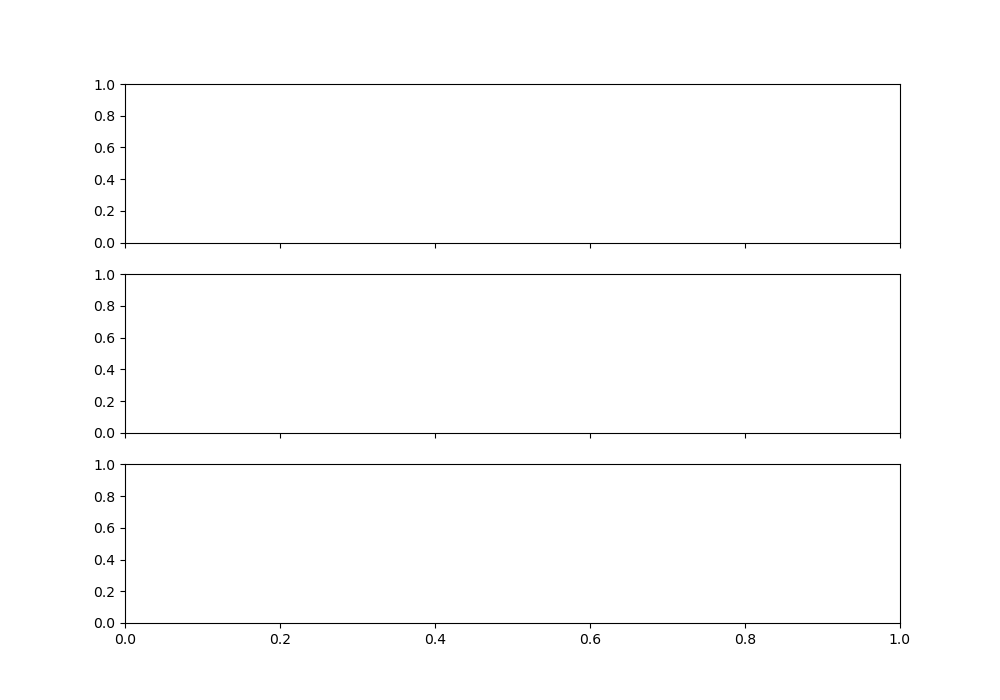

AttributeError: you must run the sampler with 'store == True' before accessing the results

In [68]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["t0", "ni", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [48]:
sampler.run_mcmc?